In [1]:
import numpy as np
import pickle
from ddc_pub import ddc_v3 as ddc
import molvecgen
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, QED, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
import pandas as pd
from ipywidgets import interact


class mol_generator:
    def __init__(self, seed_smile: str = "", sub_smile:str = "", model: str = "", qsar_model: str = ""):
        self.mols = []
        self.target = []
        self.target_names = ["logp", "tpsa", "sub_similarity", "qed", "hba", "hbd"]
        self.sani_mols = []
        self.sani_properties = []
        self.data = None
        self.set_seed(seed_smile)
        self.set_sub(sub_smile)
        self.set_model(model)
        self.set_qsar_model(qsar_model)

    def set_seed(self, seed_smile):
        if(seed_smile == ""):
            return
        #self.seed_smile = seed_smile
        self.seed_mol = Chem.MolFromSmiles(seed_smile)

        print("Seed Molecular:")
        display(self.seed_mol)

    def set_sub(self, sub_smile):
        if(sub_smile == ""):
            return
        self.sub_mol = Chem.MolFromSmiles(sub_smile)

        print("Substruct:")
        display(self.sub_mol)

    def set_model(self, model):
        if(model == ""):
            return
        self.model = ddc.DDC(model_name=model)

    def set_qsar_model(self, qsar_model):
        if(qsar_model == ""):
            return
        self.qsar_model = pickle.load(open(qsar_model, "rb"))["classifier_sv"]

    #Calculate the similarity between the aimed substructure and generated mol
    def get_sim(self, mol, sub_mol) -> float: 
        try:
            res = rdFMCS.FindMCS([mol, sub_mol], timeout=1, bondCompare=rdFMCS.BondCompare.CompareAny, ringMatchesRingOnly=True, atomCompare=rdFMCS.AtomCompare.CompareAny)
            if res.smartsString == "" or res.canceled:
                return 0
            mcs_mol = Chem.MolFromSmarts(res.smartsString)
            Chem.SanitizeMol(mcs_mol)

            mcs_mol_fp = AllChem.GetMorganFingerprintAsBitVect(mcs_mol, 2, nBits=2048)
            sub_mol_fp = AllChem.GetMorganFingerprintAsBitVect(sub_mol, 2, nBits=2048)
            sim = DataStructs.FingerprintSimilarity(sub_mol_fp, mcs_mol_fp)

            return sim
        except Exception as e:
            print("...Exception Occurred at {:1}:".format(Chem.MolToSmiles(mol)))
            print(e)
            return 0

    def get_descriptors(self, mol):
        logp = Descriptors.MolLogP(mol)
        tpsa = Descriptors.TPSA(mol)
        sim = self.get_sim(mol, self.sub_mol)
        hba = rdMolDescriptors.CalcNumHBA(mol)
        hbd = rdMolDescriptors.CalcNumHBD(mol)
        qed = QED.qed(mol)
        
        return [logp, tpsa, sim, qed, hba, hbd]

    def sanitize(self, mol):  # 检查分子
        try:
            Chem.SanitizeMol(mol)
            return mol
        except Exception as e:
            print(e)

    # 采样指定性质的分子
    def sample(self, sample_times: int = 4, conditions: list = [None]*6):
        # 确定目标
        #assert len(conditions) >= 7
        self.target = self.get_descriptors(self.seed_mol)
        for i in range(len(conditions)):
            if(conditions[i] != None):
                self.target[i] = conditions[i]
        self.target = np.array(self.target)
        print("target:{:}".format(self.target))
        # 采样
        smiles_out = []
        self.model.batch_input_length = 256  # 太大会减慢速度
        for i in range(sample_times):
            smiles, _ = self.model.predict_batch(latent=self.target.reshape(1, -1), temp=1.0)
            smiles_out.append(smiles)
        smiles_out = np.concatenate(smiles_out)
        self.mols = [Chem.MolFromSmiles(smi) for smi in smiles_out]
        # 检查分子
        self.sani_mols.clear()
        self.sani_properties.clear()
        for mol in self.mols:
            if(mol != None):
                self.sani_mols.append(self.sanitize(mol))
        for mol in self.sani_mols:
            if(mol != None):
                self.sani_properties.append(self.get_descriptors(mol))
        # 打印结果
        print("生成分子数:{:},有效性:{:}".format(
            len(self.mols), len(self.sani_mols)/len(self.mols)))

    def show_data(self, n=5):  # 以表格形式显示生成的分子的属性
        self.data = pd.DataFrame(self.sani_properties,
                                 columns=self.target_names, copy=True)
        display(self.data.head(n))

    def plot(self):  # 绘制样品分布
        target_dict = {t[0]: t[1] for t in zip(self.target_names, self.target)}
        axes = self.data.hist(bins=25, figsize=(8, 6))
        for i, ax in enumerate(axes.flatten()):
            title = ax.title.__dict__["_text"]
            if title:
                ax.axvline(x=target_dict[title], color='r',
                           linestyle='dashed', linewidth=2)

    def showmol(self, i):  # 根据id显示生成的分子
        display(self.sani_mols[i])

    def interact(self):  # 显示下拉菜单
        _ = interact(self.showmol, i=range(len(self.sani_mols)))


Seed Molecular:


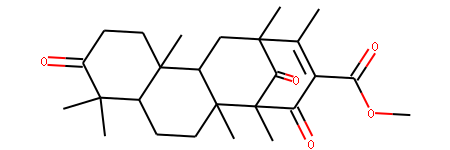

Substruct:


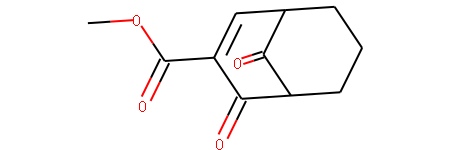

Initializing model in test mode.
Loading model.
'mol_to_latent_model' not found, setting to None.
Loading finished in 4 seconds.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Latent_Input (InputLayer)       [(None, 6)]          0                                            
__________________________________________________________________________________________________
Decoder_Inputs (InputLayer)     [(None, 142, 35)]    0                                            
__________________________________________________________________________________________________
latent_to_states_model (Model)  [(None, 512), (None, 33792       Latent_Input[0][0]               
__________________________________________________________________________________________________
batch_model (Model)             (None, 142, 35)      5350947    

In [2]:
rdBase.DisableLog("rdApp.*")
#创建生成器
generator_1 = mol_generator() 
#设置种子
#generator_1.set_seed("CN(C)CCCN1C2=CC=CC=C2SC3=C1C=C(C=C3)Cl") 
#generator_1.set_seed("CC1(C)C(CC[C@@]2(C)[C@@]1([H])CC[C@@]([C@@]34C)(C)[C@]2([H])C[C@@](C)(C4=O)C(C)=C(C(OC)=O)C3=O)=O")
generator_1.set_seed("CC1(C)C(CCC2(C)C1CCC(C34C)(C)C2CC(C)(C4=O)C(C)=C(C(OC)=O)C3=O)=O")
generator_1.set_sub("O=C(OC)C1=CC(C2=O)CCCC2C1=O")
#设置生成模型
generator_1.set_model("models/model_0808") 
#设置QSAR模型
#generator_1.set_qsar_model("models/qsar_model.pickle") 


In [3]:
#generator_1.sample(8, conditions=[1.5,30,1]+[None]*4) #这里把采样和生成放在一起了
generator_1.sample(8)


target:[ 4.4719     77.51        1.          0.34974601  5.          0.        ]
生成分子数:2048,有效性:0.853515625


In [4]:
generator_1.show_data(10)


,logp,tpsa,sub_similarity,qed,hba,hbd
0,4.74380,68.28,0.068966,0.495671,4,0
1,4.78620,77.51,0.129630,0.486077,5,0
2,4.06920,78.90,0.125000,0.505840,6,0
3,5.57720,69.67,0.122807,0.520314,5,0
4,6.17500,60.44,0.367347,0.275970,4,0
5,5.78842,69.67,0.122807,0.311178,5,0
6,4.95520,69.67,0.120690,0.548132,5,0
7,5.11770,72.80,0.250000,0.440447,5,0
8,5.42102,77.51,0.122807,0.326721,5,0
9,5.11500,69.67,0.245283,0.469005,5,0



Bad key "text.kerning_factor" on line 4 in
d:\Anaconda\Anaconda3\envs\ddc_env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


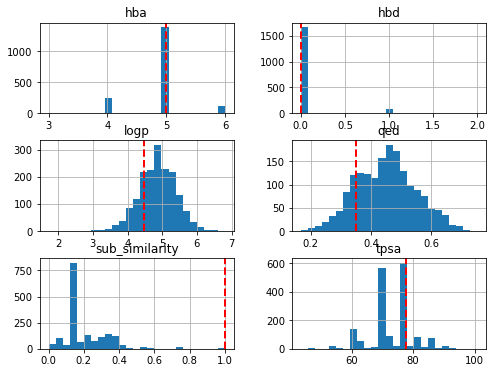

In [5]:
generator_1.plot()


In [6]:
generator_1.interact()


interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [7]:
generator_1.data.sort_values("sub_similarity").tail(20)

,logp,tpsa,sub_similarity,qed,hba,hbd
1729,4.81270,69.67,0.736842,0.483853,5,0
425,4.93170,60.44,0.736842,0.459995,4,0
1474,4.52310,77.51,0.736842,0.350776,5,0
1280,5.14880,60.44,0.736842,0.356158,4,0
1103,5.26700,69.67,0.736842,0.343920,5,0
1028,3.81892,69.67,0.736842,0.570141,5,0
217,5.32630,63.68,0.736842,0.422960,4,0
681,5.57880,58.97,0.736842,0.489730,5,0
659,5.34662,63.68,0.736842,0.576913,4,0
1235,3.80690,77.51,0.736842,0.559382,5,0
